# Extended Kalman Filter localization example
We are considering a robot with differential traction with a rotary sensor on its top. It detects beacons and obtain a measure of its distance and angle to the robot refential frame.
Whenever we observe a beacon there is an error in the estimated angle and an error in estimating the distance. We assume that the standard deviation of the distance error increases proportionally with distance.

This work is inspired on "Laboratorial Work 4 - Robot localization based on beacons" from the course "Sistemas Robóticos Autónomos" at FEUP.
More specifically we are talking about a soccer robot in a small soccer field with the beacons in the four corner. The robot uses first a rotative of a camera and then an omnidirectional camera in the second part. 

## 1. Extended Kalman Filter implementation in robot simulator
We start by importing numpy

In [1]:
import numpy as np

and setting the initial state of the robot at

In [2]:
x = np.array([2, -2, 0])

Differently from MATLAB at this stage does not make sense to distinguish from "horizontal" or "vertical" vectors.

We are going to simulate

In [3]:
N = 300

time intervals, each of lenght

In [4]:
dt = 0.040

Now we generate the control signals of the robot for each time interval

In [5]:
v_t = np.random.normal(0,1,N) + 1 #linear velocity
omega_t = np.random.normal(0,1,N)*0.5 + 0.5 #angular velocity

and we group them in

In [6]:
u_t = np.array([v_t,omega_t])

We set the matrices of covariances...

In [7]:
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
Q = np.array([[0.1**2, 0], [0, 0.05**2]]) # covariance belief exteroceptive measurments

Standard deviation of the error of measurment for the beacons

In [8]:
sdv_dist_1m = 0.05
sdv_ang = 0.01

We set the location of the first two beacons in the map

In [9]:
xb1 = 5
yb1 = -2.5
xb2 = 5
yb2 = 2.5

The initial value for the extimated/predicted state/position of the robot is

In [10]:
x_e = np.array([2.5, -2.5, 0])

Initialize to zeros the variables to record the simulation 

In [11]:
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

### Simulation

What's this?
TODO: add a cool latex equation here representing the multi-line comment below

In [12]:
from math import sin, cos, sqrt, atan2
def F(t,y,u):
    '''
    Simulation of a mobile robot
    State vector:   X(t)=[displacement along x axis - x(t)
                          displacement along y axis - y(t)
                          angular position - a(t)]
                          
                    u(t)=[linear velocity - v(t)
                          angular velocity - w(t)]
    Equations: dx(t)/dt = v(t)*cos(a(t))
               dy(t)/dt = v(t)*sin(a(t))
               da(t)/dt = w(t)
    '''
    # return dy/dt = f(t,y).
    return np.array([u[0]*cos(y[2]), u[0]*sin(y[2]), u[1]])

In the simulation we need to solve a differential equation, so we will need

In [13]:
from scipy.integrate import solve_ivp

Initialize counter to change from one beacon to the other

In [14]:
p_count = 0

We can start the simulation

In [15]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = theta_r_e + omega * dt

    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))

    # counter to change from one beacon to the other
    p_count += 1

    if p_count==100:
        p_count=0 

    if p_count <= 50: # beacon 1
        # simulation of the observed measures
        distp = sqrt((xb1 - xr)**2 + (yb1 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        theta_p = atan2(yb1 - yr, xb1 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang
        z = np.array([distp_measured, theta_p_measured])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb1 - xr_e)**2 + (yb1 - yr_e)**2)
        theta_p_e = atan2(yb1 - yr_e, xb1 - xr_e) - theta_r_e
        z_e = np.array([distp_e, theta_p_e])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, sdv_ang**2]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb1-xr_e)/distp_e, -(yb1-yr_e)/distp_e, 0],
                              [(yb1-yr_e)/(distp_e**2), -(xb1-xr_e)/(distp_e**2), -1]])           
    else: # beacon 2
        # simulation of the observed measures
        distp = sqrt((xb2 - xr)**2 + (yb2 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        theta_p = atan2(yb2 - yr, xb2 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang
        z = np.array([distp_measured, theta_p_measured])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb2 - xr_e)**2 + (yb2 - yr_e)**2)
        theta_p_e = atan2(yb2 - yr_e, xb2 - xr_e) - theta_r_e
        z_e = np.array([distp_e, theta_p_e])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, sdv_ang**2]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb2-xr_e)/distp_e, -(yb2-yr_e)/distp_e, 0],
                              [(yb2-yr_e)/(distp_e**2), -(xb2-xr_e)/(distp_e**2), -1]])


    # Kalman gain
    k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

    # covariance update
    P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)

    # update expected state
    x_e = x_e + np.dot(k, np.transpose(z - z_e))

### Visualize the results
Let's see what we got...

<IPython.core.display.Javascript object>


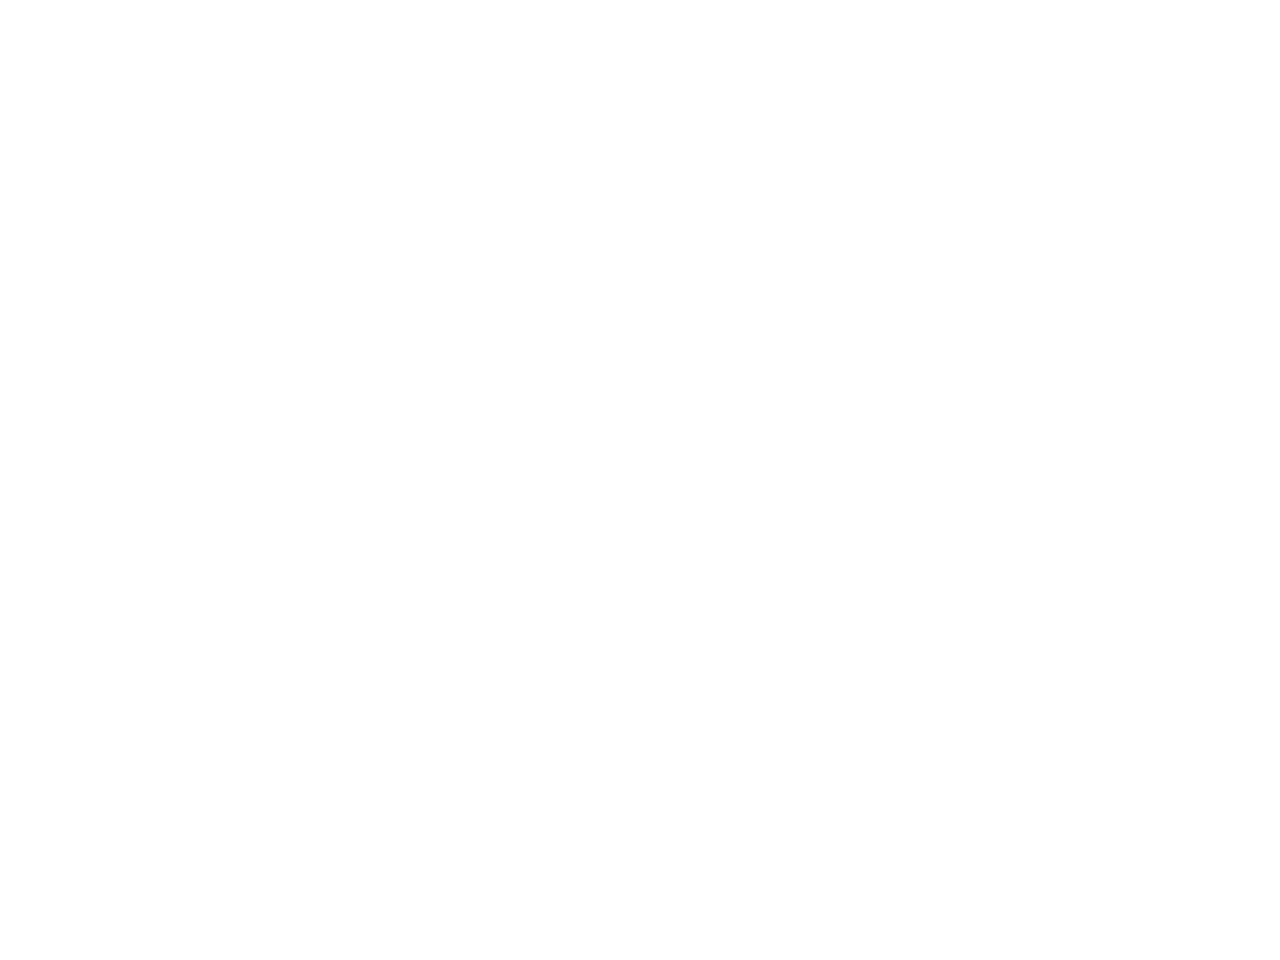

In [16]:
import matplotlib.pyplot as plt
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
     x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
     x_e_t[:,0],   x_e_t[:,1] ,'o',
     x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
     xb1, yb1 ,'p', xb2, yb2, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

## 2. Implementation considering only angle or distance measure
We need to change some things...

### Only angle measure

Reset the values needed to retake the simulation. We set an expected initial angle quite far from the real one.

In [17]:
x = np.array([2, -2, 0]) # real initial state
x_e = np.array([2.5, -2.5, 0.8]) # expected initial state, different angle
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

And then back to the simulation

In [18]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = theta_r_e + omega * dt

    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))

    # counter to change from one beacon to the other
    p_count += 1

    if p_count==100:
        p_count = 0 
    
    # covariance matrix of the measures noise
    R = np.array([[0, 0],
                  [0, sdv_ang**2]])
     
    if p_count <= 50: # beacon 1
        # simulation of the observed measures
        theta_p = atan2(yb1 - yr, xb1 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang

        # expected values for the measures taking into account the state of the robot z = h(X)
        theta_p_e = atan2(yb1 - yr_e, xb1 - xr_e) - theta_r_e
         
    else: # beacon 2
        # simulation of the observed measures
        theta_p = atan2(yb2 - yr, xb2 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang

        # expected values for the measures taking into account the state of the robot z = h(X)
        theta_p_e = atan2(yb2 - yr_e, xb2 - xr_e) - theta_r_e
        
    # calculation of dH/dX
    grad_h_X  = np.array([[1, 0, 0],
                          [0, 1, -1]])
    
    z = np.array([0, theta_p_measured])
    z_e = np.array([0, theta_p_e])

    # Kalman gain
    k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

    # covariance update
    P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)

    # update expected state
    x_e = x_e + np.dot(k, np.transpose(z - z_e))

Let's print the results also in this case

<IPython.core.display.Javascript object>


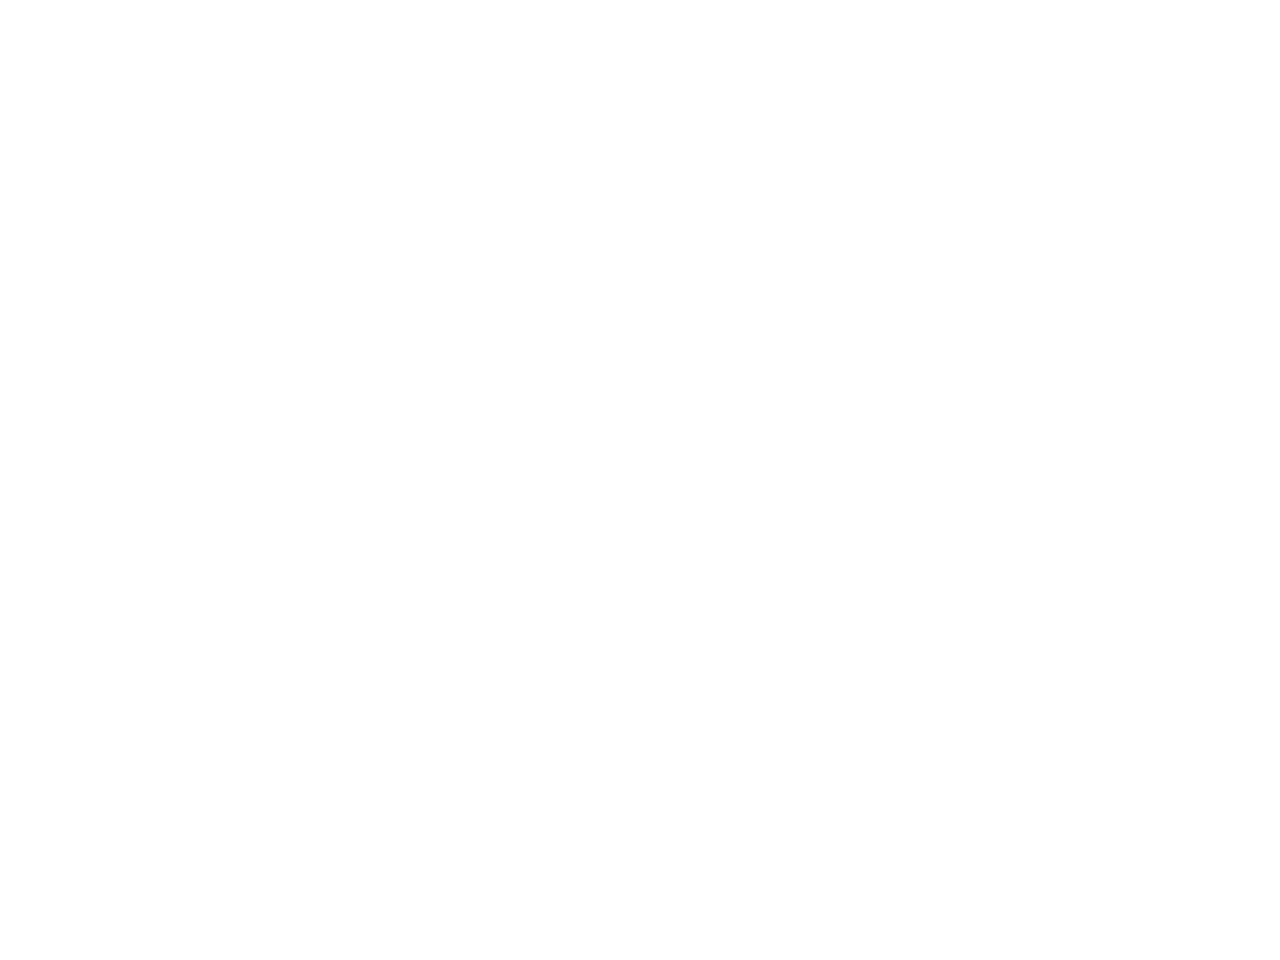

In [19]:
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
     x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
     x_e_t[:,0],   x_e_t[:,1] ,'o',
     x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
     xb1, yb1 ,'p', xb2, yb2, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

As one could have imagined the expected value after little time tracks perfectly the angle but does not recover from being in the wrong position.

### Only distance measure

Again, we reset the simulation

In [20]:
x = np.array([2, -2, 0]) # real initial state
x_e = np.array([2.5, -2.5, 0.8]) # expected initial state, different angle
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

Simulate

In [21]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = theta_r_e + omega * dt

    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))

    # counter to change from one beacon to the other
    p_count += 1

    if p_count==100:
        p_count=0 

    if p_count <= 50: # beacon 1
        # simulation of the observed measures
        distp = sqrt((xb1 - xr)**2 + (yb1 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        z = np.array([distp_measured, 0])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb1 - xr_e)**2 + (yb1 - yr_e)**2)
        z_e = np.array([distp_e, 0])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, 0]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb1-xr_e)/distp_e, -(yb1-yr_e)/distp_e, 0],
                              [(yb1-yr_e)/(distp_e**2), -(xb1-xr_e)/(distp_e**2), 0]])           
    else: # beacon 2
        # simulation of the observed measures
        distp = sqrt((xb2 - xr)**2 + (yb2 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        z = np.array([distp_measured, 0])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb2 - xr_e)**2 + (yb2 - yr_e)**2)
        z_e = np.array([distp_e, 0])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, 0]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb2-xr_e)/distp_e, -(yb2-yr_e)/distp_e, 0],
                              [(yb2-yr_e)/(distp_e**2), -(xb2-xr_e)/(distp_e**2), 0]])


    # Kalman gain
    k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

    # covariance update
    P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)

    # update expected state
    x_e = x_e + np.dot(k, np.transpose(z - z_e))

Print the result

<IPython.core.display.Javascript object>


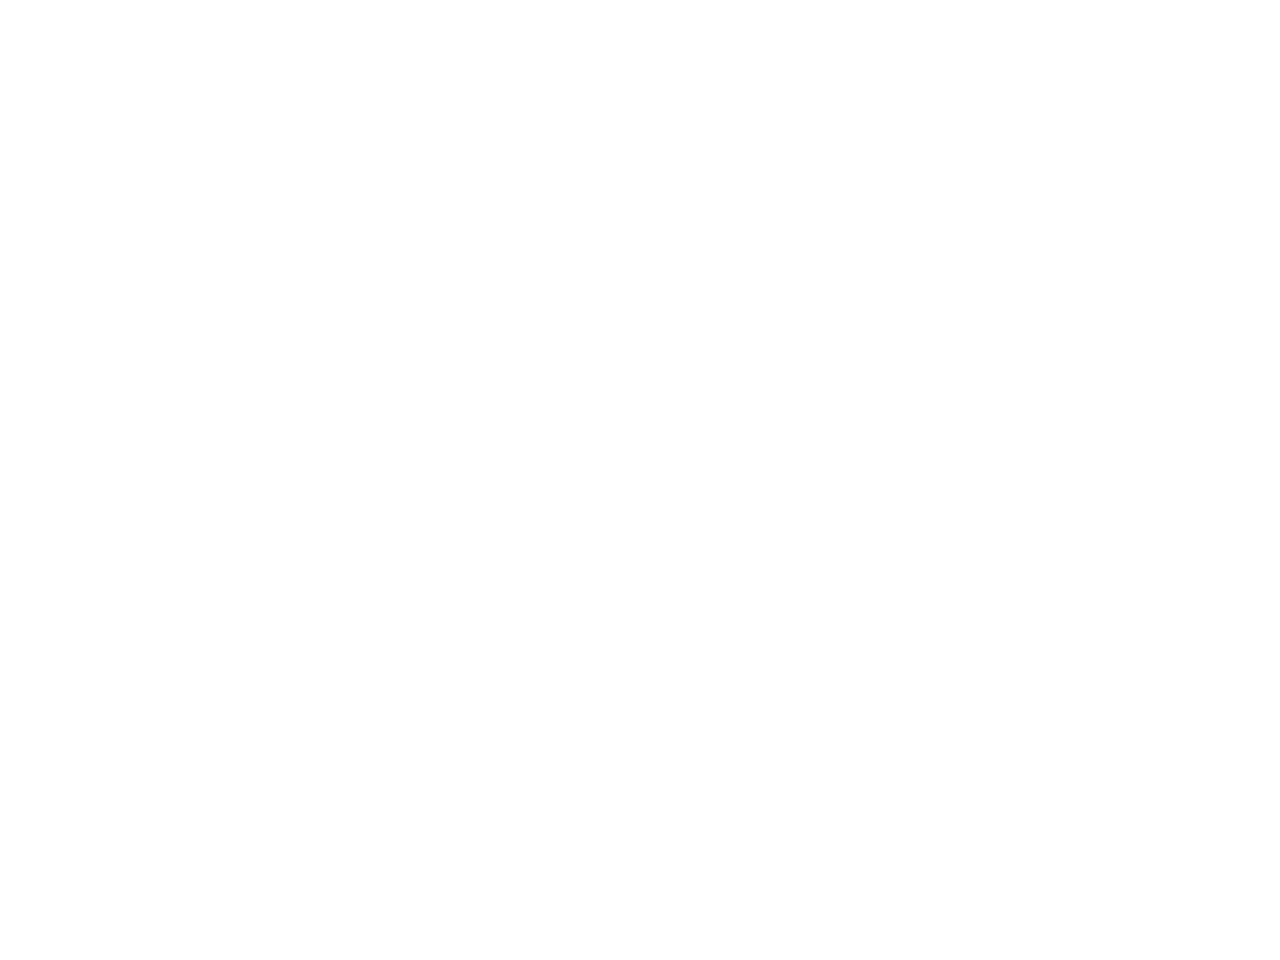

In [22]:
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
     x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
     x_e_t[:,0],   x_e_t[:,1] ,'o',
     x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
     xb1, yb1 ,'p', xb2, yb2, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

## 3. Four beacons simultaneously
Now we are pretending to use a omnidirectional camera. This gives us the ability to observe all four beacons at the same moment. We do some changes to the simulation...

First of all we set the positions of the four beacons. For doing so we define an array of objects of class "Beacon".

In [23]:
class Beacon:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
b = [Beacon(5, -2.5), Beacon(5, 2.5), Beacon(-5, 2.5), Beacon(-5, -2.5)]

Then we reset the variables for the simulation

In [24]:
x = np.array([2, -2, 0]) # real initial state
x_e = np.array([3, -2.8, 0]) # expected initial state
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

Apparently we need

In [25]:
from math import pi
def wraptopi(x):
    return x%(2*pi)

And simulate. Basically the only difference is that we loop on the update phase for each beacon.

In [26]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = wraptopi(theta_r_e + omega * dt)
    
    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))
    
    print("------ Cycle #",i," -------")
    print("expected state")
    print(x_e)
    print("real")
    print(x)
    print("P")
    print(P)

    for bi in range(0, 4):
        print("Beacon #",bi," measure update:")
        # simulation of the observed measures
        distp = sqrt((b[bi].x - xr)**2 + (b[bi].y - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        theta_p = wraptopi(atan2(b[bi].y - yr, b[bi].x - xr) - theta_r)
        theta_p_measured = wraptopi(theta_p + np.random.normal(0,1) * sdv_ang)
        z = np.array([distp_measured, theta_p_measured])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((b[bi].x - xr_e)**2 + (b[bi].y - yr_e)**2)
        theta_p_e = wraptopi(atan2(b[bi].y - yr_e, b[bi].x - xr_e) - theta_r_e)
        z_e = [distp_e, theta_p_e]
        
        print("distp ",distp)
        print("measure")
        print(z)
        print("expected measure")
        print(z_e)

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, sdv_ang**2]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(b[bi].x-xr_e)/distp_e, -(b[bi].y-yr_e)/distp_e, 0],
                              [(b[bi].y-yr_e)/(distp_e**2), -(b[bi].x-xr_e)/(distp_e**2), -1]])           

        # Kalman gain
        k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

        # covariance update
        P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)
        
        print("covariance P")
        print(P)

        # update expected state
        x_e = x_e + np.dot(k, np.transpose(z - z_e))
        x_e[2] = wraptopi(x_e[2])
        
        xr_e = x_e[0]
        yr_e = x_e[1]
        theta_r_e = x_e[2]
        
        print("Expected state")
        print(x_e)

------ Cycle # 0  -------
expected state
[ 3.01395257 -2.7998924   0.01542371]
real
[ 2.01395243 -1.9998924   0.01542371]
P
[[ 1.01599161e-03  3.62720210e-07 -7.26257882e-07]
 [ 3.62720210e-07  1.00032476e-03  3.13858121e-05]
 [-7.26257882e-07  3.13858121e-05  3.50000000e-03]]
Beacon # 0  measure update:
distp  3.0276373130440226
measure
[3.19240518 6.08550814]
expected measure
[2.0085616367591945, 0.13444371680221995]
covariance P
[[ 9.23570605e-04 -2.87783276e-06  6.81025464e-05]
 [-2.87783276e-06  9.27583971e-04 -4.43349888e-04]
 [ 6.81025464e-05 -4.43349888e-04  3.13946869e-04]]
Expected state
[ 3.02393361 -3.61935919  0.90510862]
Beacon # 1  measure update:
distp  5.4005103172825155
measure
[5.62144344 0.96853066]
expected measure
[6.430505057480173, 0.3533378175696158]
covariance P
[[ 9.10526770e-04 -7.70528364e-05  1.20258702e-04]
 [-7.70528364e-05  5.00555255e-04 -1.41486889e-04]
 [ 1.20258702e-04 -1.41486889e-04  1.00079918e-04]]
Expected state
[ 3.13731251 -2.96270233  0.4397

------ Cycle # 9  -------
expected state
[ 2.28383831 -2.14044441  0.17145944]
real
[ 2.02408503 -2.00618843  0.15032149]
P
[[ 3.29505942e-04 -1.48901257e-05  2.31683225e-05]
 [-1.48901257e-05  5.83690328e-05 -5.05870668e-05]
 [ 2.31683225e-05 -5.05870668e-05  2.52559138e-03]]
Beacon # 0  measure update:
distp  3.0166073322844853
measure
[2.99214941 5.95206511]
expected measure
[2.739856668463241, 5.9801147174303395]
covariance P
[[ 3.23433994e-04 -1.41225343e-05 -9.11496244e-06]
 [-1.41225343e-05  5.79932492e-05 -2.14666029e-05]
 [-9.11496244e-06 -2.14666029e-05  1.04715030e-04]]
Expected state
[ 2.27985825 -2.14047914  0.19861408]
Beacon # 1  measure update:
distp  5.4001670419154575
measure
[5.6131063  0.82076269]
expected measure
[5.378960660109422, 0.8419887898831577]
covariance P
[[ 3.04924664e-04 -1.82245232e-05  2.13820931e-05]
 [-1.82245232e-05  5.70829518e-05 -1.47376125e-05]
 [ 2.13820931e-05 -1.47376125e-05  5.37471885e-05]]
Expected state
[ 2.27320415 -2.14197739  0.209006

[8.68762713 2.24533211]
expected measure
[8.729566740697381, 2.2100019003838773]
covariance P
[[ 2.17897521e-04  5.84332648e-06  1.02849984e-05]
 [ 5.84332648e-06  3.84374172e-05 -4.44991421e-06]
 [ 1.02849984e-05 -4.44991421e-06  3.39677994e-05]]
Expected state
[ 2.47803231 -2.00257998  0.37731908]
Beacon # 3  measure update:
distp  7.364292949077181
measure
[7.05509373 2.83692304]
expected measure
[7.494557614899387, 2.8306932292607683]
covariance P
[[ 2.16601395e-04  6.62931972e-06  7.36032870e-06]
 [ 6.62931972e-06  3.77711393e-05 -2.02626667e-06]
 [ 7.36032870e-06 -2.02626667e-06  2.51399104e-05]]
Expected state
[ 2.47683149 -2.00217268  0.37570948]
------ Cycle # 18  -------
expected state
[ 2.56268073 -1.96702209  0.40153539]
real
[ 2.42796387 -1.88829291  0.38607824]
P
[[ 2.30364249e-04  1.11652556e-05 -4.02734775e-05]
 [ 1.11652556e-05  4.47091512e-05  1.06249577e-04]
 [-4.02734775e-05  1.06249577e-04  2.52513991e-03]]
Beacon # 0  measure update:
distp  2.6437767309427818
meas

covariance P
[[ 1.36891190e-04  2.08042566e-05  2.03127950e-06]
 [ 2.08042566e-05  3.89008899e-05 -4.74432825e-06]
 [ 2.03127950e-06 -4.74432825e-06  3.36413751e-05]]
Expected state
[ 2.80341751 -1.77319155  0.55289398]
Beacon # 3  measure update:
distp  7.765311640677982
measure
[8.42803743 2.68428522]
expected measure
[7.837191802798866, 2.6815704947443844]
covariance P
[[ 1.36759368e-04  2.08526132e-05  1.77491857e-06]
 [ 2.08526132e-05  3.82392198e-05 -2.35672360e-06]
 [ 1.77491857e-06 -2.35672360e-06  2.49735732e-05]]
Expected state
[ 2.80392871 -1.77290885  0.55221328]
------ Cycle # 30  -------
expected state
[ 2.88321182 -1.7208305   0.61015984]
real
[ 2.80552114 -1.66760115  0.60459001]
P
[[ 1.48946462e-04  2.59812412e-05 -7.03663449e-05]
 [ 2.59812412e-05  4.73408549e-05  9.47120744e-05]
 [-7.03663449e-05  9.47120744e-05  2.52497357e-03]]
Beacon # 0  measure update:
distp  2.3470460827175375
measure
[2.50884373 5.31224062]
expected measure
[2.255636784644273, 5.32032621041951

[8.105966029955951, 2.4628604812495674]
covariance P
[[ 8.86783506e-05  2.11771616e-05 -1.03085689e-06]
 [ 2.11771616e-05  4.61242947e-05 -2.89935072e-06]
 [-1.03085689e-06 -2.89935072e-06  2.49349404e-05]]
Expected state
[ 3.051726   -1.56162487  0.79435954]
------ Cycle # 38  -------
expected state
[ 3.09831242 -1.51208949  0.83777647]
real
[ 3.02829946 -1.47437596  0.84058   ]
P
[[ 9.73280023e-05  2.77068862e-05 -6.67036559e-05]
 [ 2.77068862e-05  5.63287551e-05  5.36982220e-05]
 [-6.67036559e-05  5.36982220e-05  2.52493494e-03]]
Beacon # 0  measure update:
distp  2.222500328026821
measure
[2.14298344 4.95665764]
expected measure
[2.142984559788433, 4.966289910111874]
covariance P
[[ 9.64279286e-05  2.87720050e-05 -3.39309364e-05]
 [ 2.87720050e-05  5.37396652e-05 -2.53227028e-05]
 [-3.39309364e-05 -2.53227028e-05  1.13006823e-04]]
Expected state
[ 3.09818981 -1.51178895  0.84694846]
Beacon # 1  measure update:
distp  4.436582836900116
measure
[4.10557391 0.25472468]
expected measur

[4.4065865  0.08336354]
expected measure
[4.163830628109313, 0.10071604197282324]
covariance P
[[ 5.49638281e-05  2.18999435e-05 -8.18459195e-06]
 [ 2.18999435e-05  6.50591195e-05 -1.49463303e-05]
 [-8.18459195e-06 -1.49463303e-05  5.25681023e-05]]
Expected state
[ 3.23151678 -1.27383146  1.04157249]
Beacon # 2  measure update:
distp  9.007417308987453
measure
[9.52148597 1.65957038]
expected measure
[9.055367052987966, 1.6701521855553696]
covariance P
[[ 5.38957691e-05  2.00556162e-05 -3.71507349e-06]
 [ 2.00556162e-05  6.18446425e-05 -7.16354196e-06]
 [-3.71507349e-06 -7.16354196e-06  3.37229667e-05]]
Expected state
[ 3.23074054 -1.27536126  1.04523428]
Beacon # 3  measure update:
distp  8.294500699342855
measure
[9.16459922 2.26044252]
expected measure
[8.321347841930095, 2.2440631759137544]
covariance P
[[ 5.36831115e-05  1.95111319e-05 -2.40940323e-06]
 [ 1.95111319e-05  6.03668462e-05 -3.57276888e-06]
 [-2.40940323e-06 -3.57276888e-06  2.49731273e-05]]
Expected state
[ 3.23163218

[ 3.32207265 -1.0529326   1.23804292]
Beacon # 2  measure update:
distp  9.004579487294237
measure
[9.88934883 1.50614741]
expected measure
[9.048769160775127, 1.5000465035906532]
covariance P
[[ 3.65679178e-05  1.48675854e-05 -2.66142799e-06]
 [ 1.48675854e-05  7.85406094e-05 -8.89632867e-06]
 [-2.66142799e-06 -8.89632867e-06  3.39174438e-05]]
Expected state
[ 3.32253815 -1.05193396  1.23591573]
Beacon # 3  measure update:
distp  8.42403927032598
measure
[8.3860287  2.07979793]
expected measure
[8.447575781487066, 2.0779456593279493]
covariance P
[[ 3.64621606e-05  1.43879168e-05 -1.72951241e-06]
 [ 1.43879168e-05  7.62338495e-05 -4.36959508e-06]
 [-1.72951241e-06 -4.36959508e-06  2.50196704e-05]]
Expected state
[ 3.32257432 -1.05170314  1.23544435]
------ Cycle # 56  -------
expected state
[ 3.34490232 -0.98253825  1.28162555]
real
[ 3.31356758 -0.94254575  1.2859962 ]
P
[[ 4.10072115e-05  1.78493362e-05 -9.11363363e-05]
 [ 1.78493362e-05  9.11979486e-05  1.99975752e-05]
 [-9.1136336

expected measure
[3.573032759664677, 6.048394562200231]
covariance P
[[ 2.74929455e-05  1.31978026e-05 -5.76168385e-06]
 [ 1.31978026e-05  1.02359477e-04 -1.98329283e-05]
 [-5.76168385e-06 -1.98329283e-05  5.30284338e-05]]
Expected state
[ 3.40651635 -0.70021076  1.34811708]
Beacon # 2  measure update:
distp  8.957524471497845
measure
[8.84641344 1.44327578]
expected measure
[8.995046755614617, 1.429732615075674]
covariance P
[[ 2.70653683e-05  1.15966776e-05 -2.89935627e-06]
 [ 1.15966776e-05  9.63114141e-05 -9.04193750e-06]
 [-2.89935627e-06 -9.04193750e-06  3.37666486e-05]]
Expected state
[ 3.40720162 -0.69755165  1.34340088]
Beacon # 3  measure update:
distp  8.576984605235184
measure
[8.5757269  2.04941809]
expected measure
[8.598247445206512, 2.009388045329457]
covariance P
[[ 2.69684148e-05  1.10795391e-05 -1.99624675e-06]
 [ 1.10795391e-05  9.34677851e-05 -4.04093179e-06]
 [-1.99624675e-06 -4.04093179e-06  2.49575873e-05]]
Expected state
[ 3.40823838 -0.6917911   1.33324622]
--

[8.98894638 1.32655105]
expected measure
[8.889040746854286, 1.3240694060015714]
covariance P
[[ 2.03567413e-05  7.30272481e-06 -1.80427280e-07]
 [ 7.30272481e-06  1.19536891e-04 -9.89866457e-06]
 [-1.80427280e-07 -9.89866457e-06  3.37220875e-05]]
Expected state
[ 3.47467381 -0.18194224  1.51010655]
Beacon # 3  measure update:
distp  8.770295842916637
measure
[8.86436418 1.89670633]
expected measure
[8.785982466820156, 1.8984829803465484]
covariance P
[[ 2.03533346e-05  7.23694226e-06 -8.62867143e-08]
 [ 7.23694226e-06  1.15742415e-04 -4.11812602e-06]
 [-8.62867143e-08 -4.11812602e-06  2.48996876e-05]]
Expected state
[ 3.47467777 -0.18222206  1.51055645]
------ Cycle # 71  -------
expected state
[ 3.47713331 -0.13996784  1.51493962]
real
[ 3.45573757 -0.12226226  1.5229364 ]
P
[[ 2.15675757e-05  8.20543109e-06 -5.39693864e-05]
 [ 8.20543109e-06  1.31681031e-04 -1.22370412e-06]
 [-5.39693864e-05 -1.22370412e-06  2.52489969e-03]]
Beacon # 0  measure update:
distp  2.8352042644833864
meas

distp  8.86214486273174
measure
[9.27334764 1.7626165 ]
expected measure
[8.873058755113778, 1.7805835346488381]
covariance P
[[ 1.65812413e-05  2.66106970e-08  2.09306807e-07]
 [ 2.66106970e-08  1.23839351e-04 -4.35908215e-06]
 [ 2.09306807e-07 -4.35908215e-06  2.49094875e-05]]
Expected state
[3.46370891 0.16142368 1.67056829]
------ Cycle # 79  -------
expected state
[3.46886809 0.11116298 1.67560438]
real
[3.45469366 0.12258005 1.67685742]
P
[[ 1.84258880e-05 -1.71859573e-06  6.42532111e-05]
 [-1.71859573e-06  1.39627608e-04  2.54101430e-06]
 [ 6.42532111e-05  2.54101430e-06  2.52490949e-03]]
Beacon # 0  measure update:
distp  3.0439937297994892
measure
[2.88418188 3.58527544]
expected measure
[3.0269682963521, 3.5671286729560556]
covariance P
[[ 1.66251428e-05 -2.32203857e-06 -1.75534798e-06]
 [-2.32203857e-06  1.38745299e-04 -2.15695282e-05]
 [-1.75534798e-06 -2.15695282e-05  9.94571666e-05]]
Expected state
[3.46846218 0.11023645 1.65841143]
Beacon # 1  measure update:
distp  2.83

expected state
[3.42504235 0.27335843 1.92117173]
real
[3.41518735 0.27861631 1.91934325]
P
[[ 2.07111539e-05 -1.98904350e-05 -1.94192166e-05]
 [-1.98904350e-05  1.32807003e-04 -1.21657246e-05]
 [-1.94192166e-05 -1.21657246e-05  2.52493753e-03]]
Beacon # 0  measure update:
distp  3.198802859659139
measure
[3.0064584  3.30230957]
expected measure
[3.189358643037167, 3.307690428953621]
covariance P
[[ 2.05730000e-05 -1.97366447e-05 -3.19760372e-06]
 [-1.97366447e-05  1.32189251e-04 -1.49743303e-05]
 [-3.19760372e-06 -1.49743303e-05  9.95225895e-05]]
Expected state
[3.42520418 0.27246761 1.92643753]
Beacon # 1  measure update:
distp  2.7287683392131967
measure
[2.80931418 5.3119433 ]
expected measure
[2.7279813835822844, 5.312156410742006]
covariance P
[[ 1.96805689e-05 -1.84716666e-05  3.21105404e-06]
 [-1.84716666e-05  1.29956957e-04 -2.38423058e-05]
 [ 3.21105404e-06 -2.38423058e-05  5.33950211e-05]]
Expected state
[3.42520642 0.2720699  1.92661553]
Beacon # 2  measure update:
distp  8

measure
[3.5707453  3.10937363]
expected measure
[3.355616141967661, 3.144635133344285]
covariance P
[[ 3.19663716e-05 -3.41760197e-05 -3.94441985e-06]
 [-3.41760197e-05  1.11513116e-04 -7.79381032e-06]
 [-3.94441985e-06 -7.79381032e-06  9.85542544e-05]]
Expected state
[3.35039424 0.42322916 2.11542832]
Beacon # 1  measure update:
distp  2.6577880510457423
measure
[2.83120996 5.12180634]
expected measure
[2.652202160637446, 5.067289786090003]
covariance P
[[ 2.97933155e-05 -3.12676313e-05  5.98378858e-06]
 [-3.12676313e-05  1.07437016e-04 -2.09525046e-05]
 [ 5.98378858e-06 -2.09525046e-05  5.31037079e-05]]
Expected state
[3.35598557 0.41522502 2.09024899]
Beacon # 2  measure update:
distp  8.602168814306705
measure
[9.07581879 0.792282  ]
expected measure
[8.61212990992372, 0.8068405345089205]
covariance P
[[ 2.93128730e-05 -2.94994917e-05  2.96180304e-06]
 [-2.94994917e-05  1.00896643e-04 -9.73771688e-06]
 [ 2.96180304e-06 -9.73771688e-06  3.38339562e-05]]
Expected state
[3.35686964 0

distp  2.6178122578639345
measure
[2.51178508 4.81791183]
expected measure
[2.6101596409663816, 4.829362273041712]
covariance P
[[ 4.19471358e-05 -3.66289965e-05  7.60300081e-06]
 [-3.66289965e-05  8.36306146e-05 -1.74498024e-05]
 [ 7.60300081e-06 -1.74498024e-05  5.26573292e-05]]
Expected state
[3.23966368 0.57323456 2.29047847]
Beacon # 2  measure update:
distp  8.460355305672822
measure
[9.11055709 0.62258338]
expected measure
[8.461943196273074, 0.6214015128536658]
covariance P
[[ 4.12072711e-05 -3.48408522e-05  3.89767622e-06]
 [-3.48408522e-05  7.92855140e-05 -8.40882513e-06]
 [ 3.89767622e-06 -8.40882513e-06  3.37866548e-05]]
Expected state
[3.23975747 0.57324235 2.29008965]
Beacon # 3  measure update:
distp  8.788241234864874
measure
[8.54512432 1.2077591 ]
expected measure
[8.79422660974369, 1.2084991544583294]
covariance P
[[ 4.05802150e-05 -3.36103647e-05  1.54876207e-06]
 [-3.36103647e-05  7.68594402e-05 -3.77549440e-06]
 [ 1.54876207e-06 -3.77549440e-06  2.49374983e-05]]
E

Beacon # 2  measure update:
distp  8.15047255578922
measure
[7.84192565 0.4072665 ]
expected measure
[8.15602784547065, 0.4021086156893947]
covariance P
[[ 5.90090955e-05 -3.51578193e-05  4.13728998e-06]
 [-3.51578193e-05  5.74726829e-05 -6.91709723e-06]
 [ 4.13728998e-06 -6.91709723e-06  3.37127563e-05]]
Expected state
[2.97915105 0.81364558 2.52933897]
Beacon # 3  measure update:
distp  8.633220976850476
measure
[8.75721547 0.99963468]
expected measure
[8.639855237620765, 1.0058694957827568]
covariance P
[[ 5.81912273e-05 -3.40307142e-05  1.47243715e-06]
 [-3.40307142e-05  5.59079089e-05 -3.21158510e-06]
 [ 1.47243715e-06 -3.21158510e-06  2.49348363e-05]]
Expected state
[2.9796563  0.81297228 2.53091917]
------ Cycle # 112  -------
expected state
[2.94707597 0.8345329  2.58305891]
real
[2.94096984 0.83202922 2.57564616]
P
[[ 7.02650198e-05 -4.05807239e-05 -2.38138058e-05]
 [-4.05807239e-05  6.09839321e-05 -4.61255200e-05]
 [-2.38138058e-05 -4.61255200e-05  2.52493484e-03]]
Beacon # 0

Beacon # 3  measure update:
distp  8.429224869684298
measure
[7.60828655 0.8025224 ]
expected measure
[8.434978442251296, 0.7873441345451724]
covariance P
[[ 8.63057302e-05 -2.94504518e-05  7.23363870e-07]
 [-2.94504518e-05  3.76486964e-05 -2.23028831e-06]
 [ 7.23363870e-07 -2.23028831e-06  2.48890208e-05]]
Expected state
[2.68550181 0.97372294 2.77472478]
------ Cycle # 120  -------
expected state
[2.60857372 1.00087456 2.82986319]
real
[2.60441141 0.99848754 2.82861068]
P
[[ 1.01355031e-04 -3.25979039e-05 -2.84343792e-05]
 [-3.25979039e-05  4.32407082e-05 -1.02063690e-04]
 [-2.84343792e-05 -1.02063690e-04  2.52488902e-03]]
Beacon # 0  measure update:
distp  4.240077803283735
measure
[3.85802524 2.4967367 ]
expected measure
[4.239698380187803, 2.481815082957397]
covariance P
[[ 1.01130969e-04 -3.30187733e-05 -1.58125322e-05]
 [-3.30187733e-05  3.91131036e-05 -2.73378494e-06]
 [-1.58125322e-05 -2.73378494e-06  1.00207641e-04]]
Expected state
[2.6093657  1.0010331  2.81536782]
Beacon # 

[2.30811009 1.06889542 2.98505682]
------ Cycle # 128  -------
expected state
[2.30086502 1.06995169 3.00858571]
real
[2.29836625 1.06668847 3.01472767]
P
[[ 1.35538341e-04 -2.11239120e-05 -1.91880148e-06]
 [-2.11239120e-05  2.63420042e-05 -1.06956374e-05]
 [-1.91880148e-06 -1.06956374e-05  2.52485343e-03]]
Beacon # 0  measure update:
distp  4.474381697782554
measure
[4.34855969 2.3458993 ]
expected measure
[4.475475916746749, 2.3511781636148887]
covariance P
[[ 1.35201897e-04 -2.09772390e-05 -2.05332143e-05]
 [-2.09772390e-05  2.62740573e-05 -2.16892118e-07]
 [-2.05332143e-05 -2.16892118e-07  9.98039823e-05]]
Expected state
[2.30115302 1.06984459 3.01362854]
Beacon # 1  measure update:
distp  3.0583012984963713
measure
[3.21614095 3.76268479]
expected measure
[3.054360741144064, 3.7568477981052335]
covariance P
[[ 1.24256301e-04 -1.86052330e-05  2.30792801e-06]
 [-1.86052330e-05  2.57462581e-05 -5.33212301e-06]
 [ 2.30792801e-06 -5.33212301e-06  5.01529256e-05]]
Expected state
[2.3017

Beacon # 0  measure update:
distp  4.544821648805776
measure
[4.83747388 2.20866193]
expected measure
[4.549168230169322, 2.214086943458268]
covariance P
[[ 1.58375086e-04 -6.48398669e-06 -2.55579787e-05]
 [-6.48398669e-06  1.96898729e-05 -1.96230566e-06]
 [-2.55579787e-05 -1.96230566e-06  1.00769058e-04]]
Expected state
[2.19235804 1.07989121 3.16859799]
Beacon # 1  measure update:
distp  3.148468959916719
measure
[3.20897855 3.59009249]
expected measure
[3.1463569958015354, 3.5828651415189476]
covariance P
[[ 1.45885533e-04 -5.43042271e-06 -1.02833266e-06]
 [-5.43042271e-06  1.95916448e-05 -4.18859787e-06]
 [-1.02833266e-06 -4.18859787e-06  4.99547382e-05]]
Expected state
[2.19373299 1.07972593 3.16506989]
Beacon # 2  measure update:
distp  7.332789355719471
measure
[7.67910644 6.06401887]
expected measure
[7.332596588339669, 6.064782826087839]
covariance P
[[ 1.45617279e-04 -5.60331784e-06  3.56772199e-07]
 [-5.60331784e-06  1.92977549e-05 -1.96519541e-06]
 [ 3.56772199e-07 -1.96519

Beacon # 1  measure update:
distp  3.4585301288796733
measure
[3.25156618 3.45709164]
expected measure
[3.4498532047956463, 3.461534831136814]
covariance P
[[ 1.65460829e-04  6.88430030e-06 -4.43404539e-06]
 [ 6.88430030e-06  1.78792480e-05 -3.73137592e-06]
 [-4.43404539e-06 -3.73137592e-06  4.98626774e-05]]
Expected state
[1.86438068 1.0616001  3.25392201]
Beacon # 2  measure update:
distp  7.0060661098176595
measure
[6.92558957 5.96122329]
expected measure
[7.013466789026861, 5.964299129648174]
covariance P
[[ 1.64562794e-04  6.44721703e-06 -1.02590673e-06]
 [ 6.44721703e-06  1.76068502e-05 -1.59117261e-06]
 [-1.02590673e-06 -1.59117261e-06  3.30438692e-05]]
Expected state
[1.86405928 1.06146786 3.25494662]
Beacon # 3  measure update:
distp  7.7246598046039034
measure
[7.68184726 0.36024141]
expected measure
[7.733004791343682, 0.36526549463449776]
covariance P
[[ 1.63933284e-04  6.62688478e-06 -3.01133485e-06]
 [ 6.62688478e-06  1.75277844e-05 -7.91986978e-07]
 [-3.01133485e-06 -7.9

[1.60268003 1.02289169 3.41224995]
Beacon # 2  measure update:
distp  6.767148115215784
measure
[7.25368125 5.78562921]
expected measure
[6.765887413604345, 5.792438468380082]
covariance P
[[ 1.79075667e-04  2.27166975e-05 -2.29074793e-06]
 [ 2.27166975e-05  2.01683288e-05 -1.72335461e-06]
 [-2.29074793e-06 -1.72335461e-06  3.30469552e-05]]
Expected state
[1.60263121 1.02260208 3.41451423]
Beacon # 3  measure update:
distp  7.486451103175437
measure
[7.63266508 0.22475992]
expected measure
[7.4835462336573375, 0.2171770892346805]
covariance P
[[ 1.78577031e-04  2.28067966e-05 -3.84339430e-06]
 [ 2.28067966e-05  2.01087051e-05 -1.06141941e-06]
 [-3.84339430e-06 -1.06141941e-06  2.48564829e-05]]
Expected state
[1.60245404 1.02278507 3.41263411]
------ Cycle # 153  -------
expected state
[1.61051885 1.02506966 3.42264609]
real
[1.61256192 1.02756876 3.42494385]
P
[[ 1.93324893e-04  2.70973576e-05 -6.85871786e-06]
 [ 2.70973576e-05  2.14076125e-05  9.19037847e-06]
 [-6.85871786e-06  9.1903

 [-2.21859033e-06 -3.41970125e-06  3.32448986e-05]]
Expected state
[1.22775913 0.89099018 3.54669525]
Beacon # 3  measure update:
distp  7.086052308969029
measure
[7.01527133 0.10690986]
expected measure
[7.091106976317246, 0.09350510891731822]
covariance P
[[ 1.80334653e-04  4.07442053e-05 -3.44399034e-06]
 [ 4.07442053e-05  2.82774309e-05 -2.37073550e-06]
 [-3.44399034e-06 -2.37073550e-06  2.48835407e-05]]
Expected state
[1.22715975 0.89137937 3.54335395]
------ Cycle # 161  -------
expected state
[1.17448873 0.86776195 3.58286803]
real
[1.16917238 0.86771927 3.57812958]
P
[[ 1.93419744e-04  4.63734161e-05  2.92946171e-05]
 [ 4.63734161e-05  3.34260021e-05 -6.82782926e-05]
 [ 2.92946171e-05 -6.82782926e-05  2.52488354e-03]]
Beacon # 0  measure update:
distp  5.100664011892122
measure
[5.29504825 1.98956805]
expected measure
[5.09670060403501, 1.97846917603455]
covariance P
[[ 1.91794215e-04  4.76886564e-05 -2.95566153e-05]
 [ 4.76886564e-05  3.21667724e-05 -1.31108432e-05]
 [-2.95566

covariance P
[[ 1.67083418e-04  5.67010381e-05 -3.41034365e-06]
 [ 5.67010381e-05  4.31262019e-05 -2.16302748e-06]
 [-3.41034365e-06 -2.16302748e-06  2.48557171e-05]]
Expected state
[1.09422342 0.8170637  3.73120183]
------ Cycle # 169  -------
expected state
[1.10042938 0.82128263 3.7460907 ]
real
[1.08329946 0.81704855 3.75210325]
P
[[ 1.77844856e-04  6.41956256e-05 -8.90607154e-06]
 [ 6.41956256e-05  4.84041899e-05  5.66771778e-06]
 [-8.90607154e-06  5.66771778e-06  2.52485572e-03]]
Beacon # 0  measure update:
distp  5.132577740339476
measure
[4.93661242 1.83881836]
expected measure
[5.122262133213544, 1.831611708900999]
covariance P
[[ 1.77507353e-04  6.39860267e-05 -3.11000113e-05]
 [ 6.39860267e-05  4.82320996e-05 -1.44703939e-05]
 [-3.11000113e-05 -1.44703939e-05  1.02056148e-04]]
Expected state
[1.10063103 0.82127449 3.73913412]
Beacon # 1  measure update:
distp  4.262964780266128
measure
[4.43392645 2.94776172]
expected measure
[4.245373682579519, 2.9505813516766257]
covarianc

P
[[ 1.53862543e-04  7.20499837e-05 -3.88851188e-05]
 [ 7.20499837e-05  6.69417737e-05  3.50710535e-05]
 [-3.88851188e-05  3.50710535e-05  2.52482780e-03]]
Beacon # 0  measure update:
distp  5.180172590339338
measure
[4.92376931 1.73375027]
expected measure
[5.1733039304397685, 1.7203115482758244]
covariance P
[[ 1.53740642e-04  7.22271902e-05 -2.96939087e-05]
 [ 7.22271902e-05  6.58363811e-05 -1.65853382e-05]
 [-2.96939087e-05 -1.65853382e-05  1.01999476e-04]]
Expected state
[0.93109745 0.69421696 3.88439277]
Beacon # 1  measure update:
distp  4.4522924012613485
measure
[4.51215461 2.81741815]
expected measure
[4.451608734661314, 2.8164794299349882]
covariance P
[[ 1.49061862e-04  7.05438995e-05 -1.51487003e-05]
 [ 7.05438995e-05  6.52078244e-05 -1.17110207e-05]
 [-1.51487003e-05 -1.17110207e-05  5.11794803e-05]]
Expected state
[0.93102972 0.69415042 3.88394468]
Beacon # 2  measure update:
distp  6.194247834230975
measure
[6.70659723 5.21690934]
expected measure
[6.199855335293428, 5.

[[ 1.21829812e-04  7.18124390e-05 -1.91325424e-05]
 [ 7.18124390e-05  8.70357462e-05 -2.36237763e-05]
 [-1.91325424e-05 -2.36237763e-05  1.01807760e-04]]
Expected state
[0.59787866 0.32710551 4.07971094]
Beacon # 1  measure update:
distp  4.907487543309196
measure
[5.33630317 2.65828053]
expected measure
[4.909189623447761, 2.661990231950796]
covariance P
[[ 1.20050806e-04  7.03606593e-05 -1.05819960e-05]
 [ 7.03606593e-05  8.58479946e-05 -1.64852667e-05]
 [-1.05819960e-05 -1.64852667e-05  5.21244351e-05]]
Expected state
[0.59657743 0.3261237  4.08168728]
Beacon # 2  measure update:
distp  6.001096880121151
measure
[6.01010963 4.96535722]
expected measure
[6.003950128321009, 4.972598412411159]
covariance P
[[ 1.14882882e-04  6.43010306e-05 -7.87220705e-07]
 [ 6.43010306e-05  7.86924585e-05 -4.87999547e-06]
 [-7.87220705e-07 -4.87999547e-06  3.32722085e-05]]
Expected state
[0.59530158 0.324607   4.08415495]
Beacon # 3  measure update:
distp  6.273035820614462
measure
[6.05326494 5.80538

[5.235523568869088, 2.5630478582736593]
covariance P
[[ 9.30465184e-05  6.22159256e-05 -8.26315857e-06]
 [ 6.22159256e-05  1.03044517e-04 -1.80070878e-05]
 [-8.26315857e-06 -1.80070878e-05  5.21632408e-05]]
Expected state
[0.39278095 0.00926125 4.22194767]
Beacon # 2  measure update:
distp  5.939875274786472
measure
[5.84311128 4.76234782]
expected measure
[5.940190726526039, 4.770153047666]
covariance P
[[ 8.93756771e-05  5.65136025e-05  2.02807845e-08]
 [ 5.65136025e-05  9.41178382e-05 -5.02267153e-06]
 [ 2.02807845e-08 -5.02267153e-06  3.32723437e-05]]
Expected state
[0.39155276 0.00742211 4.22460212]
Beacon # 3  measure update:
distp  5.951811424116506
measure
[6.23101585 5.6338091 ]
expected measure
[5.946091722306964, 5.635486897733487]
covariance P
[[ 8.92143039e-05  5.61523028e-05  5.84779234e-07]
 [ 5.61523028e-05  9.22928572e-05 -1.18273364e-06]
 [ 5.84779234e-07 -1.18273364e-06  2.47664181e-05]]
Expected state
[0.39186215 0.00752253 4.22502148]
------ Cycle # 194  -------
ex

expected measure
[5.9562936460580564, 4.5726009864012305]
covariance P
[[ 7.00265833e-05  4.52658969e-05  2.37242640e-07]
 [ 4.52658969e-05  1.05793101e-04 -5.22735650e-06]
 [ 2.37242640e-07 -5.22735650e-06  3.32603014e-05]]
Expected state
[ 0.23753402 -0.33705158  4.35999129]
Beacon # 3  measure update:
distp  5.661518347008389
measure
[5.59244842 5.46468318]
expected measure
[5.666578202284242, 5.456424487787784]
covariance P
[[ 6.99002476e-05  4.48393392e-05  8.41143370e-07]
 [ 4.48393392e-05  1.02957616e-04 -3.91359404e-07]
 [ 8.41143370e-07 -3.91359404e-07  2.47666129e-05]]
Expected state
[ 0.23760426 -0.33595634  4.35793536]
------ Cycle # 202  -------
expected state
[ 0.23302926 -0.34815268  4.34910471]
real
[ 0.23046072 -0.35636148  4.35310465]
P
[[ 7.20841992e-05  5.01607258e-05  1.63365328e-05]
 [ 5.01607258e-05  1.16908032e-04 -6.36047864e-06]
 [ 1.63365328e-05 -6.36047864e-06  2.52476661e-03]]
Beacon # 0  measure update:
distp  5.22911952599072
measure
[5.25127991 1.5094711

measure
[5.64994509 5.21693958]
expected measure
[5.474878548810404, 5.216374523918015]
covariance P
[[ 5.62408215e-05  3.18387136e-05  1.81671741e-06]
 [ 3.18387136e-05  1.10108564e-04 -1.00675499e-07]
 [ 1.81671741e-06 -1.00675499e-07  2.47927462e-05]]
Expected state
[ 0.15255034 -0.64851347  4.55319809]
------ Cycle # 210  -------
expected state
[ 0.14400471 -0.70151591  4.55186919]
real
[ 0.14040149 -0.71466249  4.54389374]
P
[[ 5.86701096e-05  3.40555586e-05  6.93693033e-05]
 [ 3.40555586e-05  1.25746439e-04 -1.10843736e-05]
 [ 6.93693033e-05 -1.10843736e-05  2.52479275e-03]]
Beacon # 0  measure update:
distp  5.177173721008968
measure
[4.97552135 1.38252181]
expected measure
[5.178342912810839, 1.3766163887583973]
covariance P
[[ 5.62483593e-05  3.36416499e-05 -6.85071270e-06]
 [ 3.36416499e-05  1.25670185e-04 -2.44834205e-05]
 [-6.85071270e-06 -2.44834205e-05  1.00800215e-04]]
Expected state
[ 0.14395095 -0.70158385  4.54621176]
Beacon # 1  measure update:
distp  5.8266416269450

[ 0.08951494 -1.12184397  4.65358387]
real
[ 0.08587502 -1.1287096   4.64629769]
P
[[ 4.85596531e-05  1.99119593e-05 -6.51063924e-06]
 [ 1.99119593e-05  1.29944961e-04  5.10782930e-07]
 [-6.51063924e-06  5.10782930e-07  2.52482709e-03]]
Beacon # 0  measure update:
distp  5.101868445889729
measure
[5.3990067  1.37522475]
expected measure
[5.100213486044984, 1.355984730449081]
covariance P
[[ 4.85333378e-05  1.99238253e-05 -6.33913378e-06]
 [ 1.99238253e-05  1.29682100e-04 -2.45441294e-05]
 [-6.33913378e-06 -2.45441294e-05  1.00979209e-04]]
Expected state
[ 0.08932625 -1.12196204  4.63510909]
Beacon # 1  measure update:
distp  6.108695251100407
measure
[6.4217968 2.2784223]
expected measure
[6.10191164166216, 2.283574069041149]
covariance P
[[ 4.81468819e-05  1.94743332e-05 -2.14160813e-06]
 [ 1.94743332e-05  1.29146059e-04 -1.98704187e-05]
 [-2.14160813e-06 -1.98704187e-05  5.21021226e-05]]
Expected state
[ 0.08893407 -1.12252311  4.63771545]
Beacon # 2  measure update:
distp  6.2476922

[4.88723742 1.14880203]
expected measure
[5.019949421738825, 1.138313574274183]
covariance P
[[ 4.72957628e-05 -4.94256284e-06 -3.01756065e-06]
 [-4.94256284e-06  1.29695086e-04 -2.45569200e-05]
 [-3.01756065e-06 -2.45569200e-05  1.01084188e-04]]
Expected state
[ 0.09831257 -1.41827941  4.91757738]
Beacon # 1  measure update:
distp  6.274157276900892
measure
[6.23527276 2.01801182]
expected measure
[6.275305025267168, 2.039966791185452]
covariance P
[[ 4.69335766e-05 -5.30185916e-06  1.12397912e-06]
 [-5.30185916e-06  1.29318782e-04 -2.06170942e-05]
 [ 1.12397912e-06 -2.06170942e-05  5.22949292e-05]]
Expected state
[ 0.09740274 -1.41912489  4.92846586]
Beacon # 2  measure update:
distp  6.4215789844429585
measure
[6.39959004 3.85039274]
expected measure
[6.429856493788033, 3.840857368818212]
covariance P
[[ 4.68727433e-05 -5.87510790e-06  2.03842611e-06]
 [-5.87510790e-06  1.21103552e-04 -8.23343570e-06]
 [ 2.03842611e-06 -8.23343570e-06  3.35061761e-05]]
Expected state
[ 0.09755105 -1

measure
[6.28267247 2.01762297]
expected measure
[6.402812965339813, 2.019910392957999]
covariance P
[[ 4.94654454e-05 -2.12204892e-05  5.79327814e-06]
 [-2.12204892e-05  1.27255180e-04 -2.04005143e-05]
 [ 5.79327814e-06 -2.04005143e-05  5.24077936e-05]]
Expected state
[ 0.15522357 -1.6861954   4.97699881]
Beacon # 2  measure update:
distp  6.6441235337796
measure
[6.63578847 3.75538511]
expected measure
[6.640825400350543, 3.765745861486987]
covariance P
[[ 4.93605013e-05 -2.04235921e-05  4.55887706e-06]
 [-2.04235921e-05  1.20167479e-04 -8.95868146e-06]
 [ 4.55887706e-06 -8.95868146e-06  3.37604639e-05]]
Expected state
[ 0.15545547 -1.68837394  4.98055989]
Beacon # 3  measure update:
distp  5.219302643371782
measure
[5.74424093 4.58471793]
expected measure
[5.218951810447267, 4.60036699408662]
covariance P
[[ 4.86408819e-05 -1.81716370e-05  2.07737467e-06]
 [-1.81716370e-05  1.12814896e-04 -8.59815137e-07]
 [ 2.07737467e-06 -8.59815137e-07  2.48395348e-05]]
Expected state
[ 0.1568944

distp  7.0661106226622215
measure
[6.20803873 3.51439216]
expected measure
[7.071198125998921, 3.527550408181373]
covariance P
[[ 6.17111000e-05 -3.76797992e-05  7.77610002e-06]
 [-3.76797992e-05  1.12886393e-04 -9.59893625e-06]
 [ 7.77610002e-06 -9.59893625e-06  3.40832515e-05]]
Expected state
[ 0.34585283 -2.13061639  5.18799187]
Beacon # 3  measure update:
distp  5.357888964692767
measure
[5.12440875 4.31598814]
expected measure
[5.358599324177843, 4.305773664004976]
covariance P
[[ 5.99541324e-05 -3.42440497e-05  3.82420867e-06]
 [-3.42440497e-05  1.06063148e-04 -1.71738047e-06]
 [ 3.82420867e-06 -1.71738047e-06  2.49688161e-05]]
Expected state
[ 0.3445448  -2.12829143  5.18539169]
------ Cycle # 243  -------
expected state
[ 0.37722685 -2.19160693  5.19239779]
real
[ 0.37757232 -2.18543785  5.19763533]
P
[[ 6.64813060e-05 -3.94530844e-05  8.42555902e-05]
 [-3.94530844e-05  1.19204571e-04  4.05157490e-05]
 [ 8.42555902e-05  4.05157490e-05  2.52496882e-03]]
Beacon # 0  measure updat

Beacon # 3  measure update:
distp  5.491577437711461
measure
[5.21199406 4.07069913]
expected measure
[5.488334256938207, 4.0698170601906405]
covariance P
[[ 7.80725356e-05 -4.91116644e-05  4.54782304e-06]
 [-4.91116644e-05  9.62758405e-05 -2.99996954e-06]
 [ 4.54782304e-06 -2.99996954e-06  2.50139565e-05]]
Expected state
[ 0.48597816 -2.35327597  5.38139132]
------ Cycle # 251  -------
expected state
[ 0.49983197 -2.37093885  5.37363184]
real
[ 0.50350084 -2.36917632  5.3779329 ]
P
[[ 8.44131711e-05 -5.66833038e-05  2.72046259e-05]
 [-5.66833038e-05  1.06342082e-04  1.44885527e-05]
 [ 2.72046259e-05  1.44885527e-05  2.52501396e-03]]
Beacon # 0  measure update:
distp  4.498401885768704
measure
[4.64346086 0.87511367]
expected measure
[4.5020183329434715, 0.8808821426818145]
covariance P
[[ 8.41806025e-05 -5.67988106e-05  1.26489718e-05]
 [-5.67988106e-05  1.05731253e-04 -2.16821472e-05]
 [ 1.26489718e-05 -2.16821472e-05  1.00619640e-04]]
Expected state
[ 0.49962564 -2.37068931  5.37912

------ Cycle # 259  -------
expected state
[ 0.65787061 -2.51160419  5.63388668]
real
[ 0.66302046 -2.51374236  5.63035342]
P
[[ 1.13871636e-04 -6.61088289e-05  4.66848067e-05]
 [-6.61088289e-05  8.96172453e-05  5.23862323e-05]
 [ 4.66848067e-05  5.23862323e-05  2.52516324e-03]]
Beacon # 0  measure update:
distp  4.337001313792097
measure
[4.07315961 0.66837699]
expected measure
[4.342144896820534, 0.6519710819632847]
covariance P
[[ 1.13228589e-04 -6.68129375e-05  1.66365954e-05]
 [-6.68129375e-05  8.75114494e-05 -1.74402996e-05]
 [ 1.66365954e-05 -1.74402996e-05  9.96251387e-05]]
Expected state
[ 0.65832217 -2.51243607  5.61829758]
Beacon # 1  measure update:
distp  6.629253652372798
measure
[6.43325522 1.51797844]
expected measure
[6.631340866692257, 1.5218706659593284]
covariance P
[[ 1.13181659e-04 -6.68350431e-05  1.80392229e-05]
 [-6.68350431e-05  8.74997412e-05 -1.68605282e-05]
 [ 1.80392229e-05 -1.68605282e-05  5.26498749e-05]]
Expected state
[ 0.65830782 -2.51241923  5.620200

covariance P
[[ 1.52863799e-04 -6.54167376e-05  1.70011444e-05]
 [-6.54167376e-05  6.35614727e-05 -9.40631783e-06]
 [ 1.70011444e-05 -9.40631783e-06  3.48974131e-05]]
Expected state
[ 1.08901554 -2.77299536  5.85307995]
Beacon # 3  measure update:
distp  6.09388094233278
measure
[5.86018198 3.53556315]
expected measure
[6.09513221310621, 3.5268939474700147]
covariance P
[[ 1.47540969e-04 -6.16186848e-05  1.00497402e-05]
 [-6.16186848e-05  6.08306511e-05 -4.35619228e-06]
 [ 1.00497402e-05 -4.35619228e-06  2.54287810e-05]]
Expected state
[ 1.08698292 -2.77163001  5.85079409]
------ Cycle # 267  -------
expected state
[ 1.12642299 -2.7896447   5.85865245]
real
[ 1.12721578 -2.78587091  5.84562678]
P
[[ 1.61433190e-04 -6.68058411e-05  3.26301810e-05]
 [-6.68058411e-05  6.41722730e-05  4.61258152e-05]
 [ 3.26301810e-05  4.61258152e-05  2.52542878e-03]]
Beacon # 0  measure update:
distp  3.8833207128088567
measure
[3.67543017 0.50528488]
expected measure
[3.8843909264274523, 0.49916844014576

 [ 2.06781713e-05 -1.02243562e-05  9.88661581e-05]]
Expected state
[ 1.34026184 -2.85570839  6.09579526]
Beacon # 1  measure update:
distp  6.480745063915024
measure
[6.88809992 1.15279351]
expected measure
[6.486701454324681, 1.1587333653760838]
covariance P
[[ 2.08870535e-04 -5.56065978e-05  2.59209722e-05]
 [-5.56065978e-05  4.17200941e-05 -1.04596942e-05]
 [ 2.59209722e-05 -1.04596942e-05  5.26653491e-05]]
Expected state
[ 1.3396606  -2.85570546  6.09865065]
Beacon # 2  measure update:
distp  8.302471782368645
measure
[8.71253572 2.60563854]
expected measure
[8.299088960392279, 2.6246635379057404]
covariance P
[[ 2.07206381e-04 -5.45547678e-05  2.08527499e-05]
 [-5.45547678e-05  4.10356776e-05 -7.05033122e-06]
 [ 2.08527499e-05 -7.05033122e-06  3.50658072e-05]]
Expected state
[ 1.34198242 -2.85712197  6.10518606]
Beacon # 3  measure update:
distp  6.356346841760649
measure
[6.13114649 3.26015419]
expected measure
[6.352029365136596, 3.2633405242359124]
covariance P
[[ 2.01267664e-0

Beacon # 2  measure update:
distp  8.61574516819634
measure
[8.95455809 2.47354851]
expected measure
[8.612296076948763, 2.4836638399611255]
covariance P
[[ 2.52477775e-04 -3.16672684e-05  2.34983859e-05]
 [-3.16672684e-05  2.66095983e-05 -4.67331009e-06]
 [ 2.34983859e-05 -4.67331009e-06  3.52085864e-05]]
Expected state
[ 1.71616308 -2.89324468  6.26796496]
Beacon # 3  measure update:
distp  6.733522546051927
measure
[6.73355072 3.10658227]
expected measure
[6.72766585504072, 3.0983277935949367]
covariance P
[[ 2.46985447e-04 -3.00104007e-05  1.66713528e-05]
 [-3.00104007e-05  2.60912251e-05 -2.48914551e-06]
 [ 1.66713528e-05 -2.48914551e-06  2.58846498e-05]]
Expected state
[ 1.71460941 -2.89274279  6.26581066]
------ Cycle # 284  -------
expected state
[ 1.72761601 -2.89293767  6.27059607]
real
[ 1.73527952 -2.88923594  6.27312006]
P
[[ 2.62988217e-04 -2.99558904e-05  1.68405794e-05]
 [-2.99558904e-05  2.61382584e-05  1.41067720e-05]
 [ 1.68405794e-05  1.41067720e-05  2.52588465e-03]

Expected state
[ 1.92181616 -2.87533246  0.11073291]
Beacon # 3  measure update:
distp  6.944012306637241
measure
[7.0779894  2.96042491]
expected measure
[6.931984810340234, 2.9766882292180354]
covariance P
[[ 2.79466137e-04 -6.63902785e-06  1.81588210e-05]
 [-6.63902785e-06  2.01969315e-05 -6.28278617e-07]
 [ 1.81588210e-05 -6.28278617e-07  2.59166218e-05]]
Expected state
[ 1.92490951 -2.87590874  0.11496155]
------ Cycle # 292  -------
expected state
[ 1.85281632 -2.88629564  0.17122113]
real
[ 1.86182173 -2.88481407  6.45407324]
P
[[ 2.95497947e-04 -5.50908952e-06  3.65629722e-05]
 [-5.50908952e-06  2.42320063e-05 -9.17224362e-05]
 [ 3.65629722e-05 -9.17224362e-05  2.52591662e-03]]
Beacon # 0  measure update:
distp  3.161683841370592
measure
[3.01076163 6.2270115 ]
expected measure
[3.170802650940408, 6.234096554726715]
covariance P
[[ 2.91918050e-04 -4.71773793e-06  1.36013313e-05]
 [-4.71773793e-06  2.14897146e-05 -1.01754415e-05]
 [ 1.36013313e-05 -1.01754415e-05  1.00872310e-04

[[2.90409591e-04 2.31607279e-05 1.75221590e-05]
 [2.31607279e-05 2.40507658e-05 5.45320831e-07]
 [1.75221590e-05 5.45320831e-07 2.58440027e-05]]
Expected state
[ 2.03097692 -2.84026523  0.33905499]


Print the results

<IPython.core.display.Javascript object>


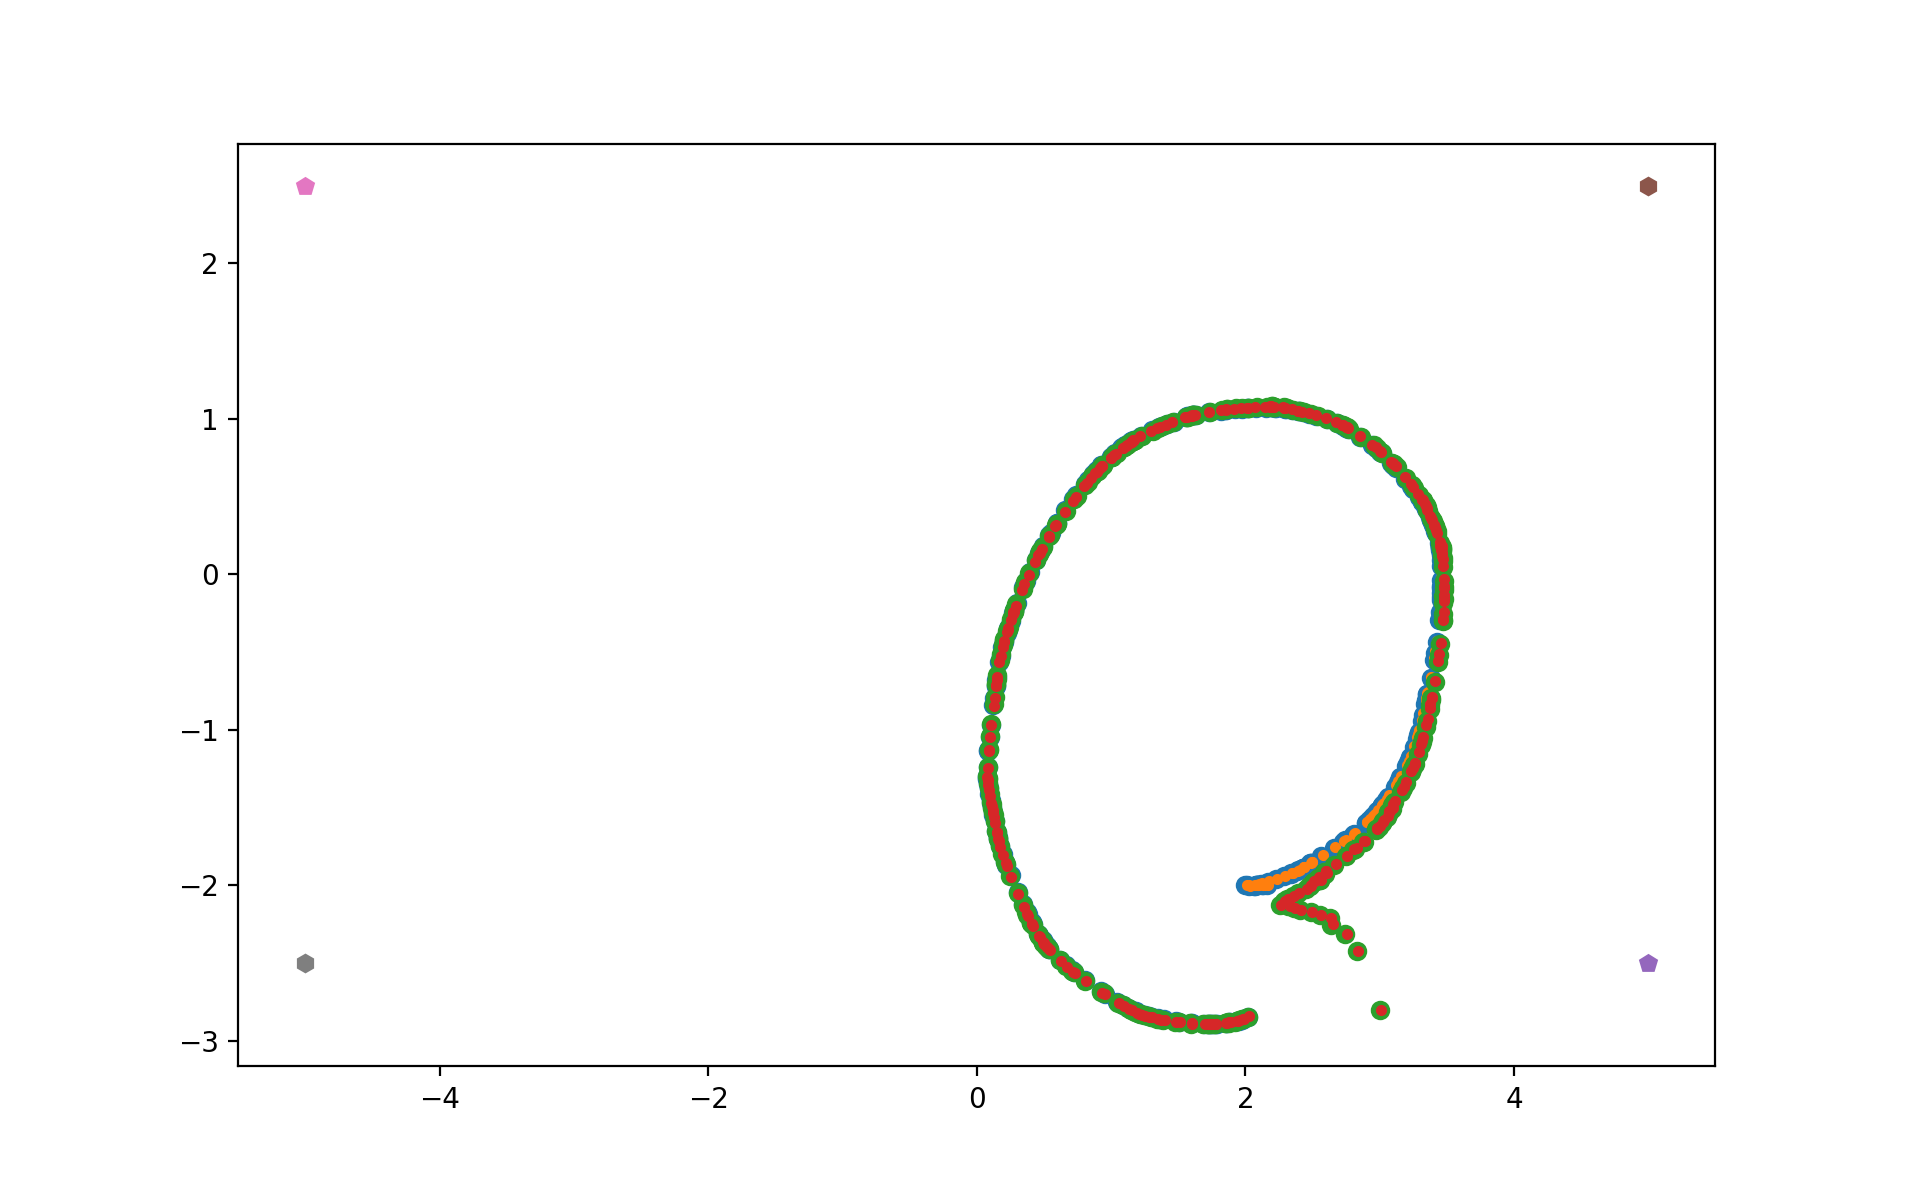

In [27]:
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
         x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
         x_e_t[:,0],   x_e_t[:,1] ,'o',
         x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
         b[0].x, b[0].y ,'p', b[1].x, b[1].y, 'h',
         b[2].x, b[2].y ,'p', b[3].x, b[3].y, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

## 4. Four beacons: only angle or distance
Content

## 5. Observations of the beacons in coordinates of the robot referential frame
Content